# Libraries Versions

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import sys

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", seaborn.__version__)

Python: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas: 2.1.4
NumPy: 1.26.4
Matplotlib: 3.8.0
Seaborn: 0.13.2


# Importing Libraries

In [480]:
import os, sys
import importlib

SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'Src'))
sys.path.append(SRC_PATH)

importlib.reload(utils)
import utils

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Preprocessing and modeling
from sklearn.preprocessing import StandardScaler

# Statistical analysis
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as sm_oi

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Loading and Overview of the Dataset

In [54]:
# importing the data
df = pd.read_csv("../data/advertising.csv")
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [67]:
# Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [201]:
# Extract the features (TV, Radio, Newspaper) and the target (Sales) from the DataFrame
X = df[['TV', 'Radio', 'Newspaper']].values
y = df['Sales'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = utils.train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets to verify the split
print(X_train.shape, X_test.shape)

(160, 3) (40, 3)


# Preprocessing the Data

In [127]:
# Compute the z-scores for the training set only
z_scores_train = np.abs(zscore(X_train))

# Define a threshold to detect outliers
threshold = 3
outliers_mask = (z_scores_train > threshold)

# Create a copy of X_train to replace outliers
X_train_clean = X_train.copy()

# Replace outliers with the median of each feature (column)
medians = np.median(X_train, axis=0)

for col in range(X_train.shape[1]):
    X_train_clean[outliers_mask[:, col], col] = medians[col]

# Apply the same strategy to X_test
# We do NOT recompute the z-scores using X_test.
# Instead, we use the median from X_train and apply the same logic
z_scores_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
outliers_mask_test = (np.abs(z_scores_test) > threshold)

X_test_clean = X_test.copy()

for col in range(X_test.shape[1]):
    X_test_clean[outliers_mask_test[:, col], col] = medians[col]

# Visualizing the Dataset

In [138]:
# Convert numpy arrays back to pandas DataFrames for easier visualization
X_train_df = pd.DataFrame(X_train_clean, columns=['TV', 'Radio', 'Newspaper'])
X_test_df = pd.DataFrame(X_test_clean, columns=['TV', 'Radio', 'Newspaper'])

y_train_df = pd.Series(y_train, name='Sales')
y_test_df = pd.Series(y_test, name='Sales')

# Concatenate features and target into a single training DataFrame
train_df = pd.concat([X_train_df, y_train_df], axis=1)

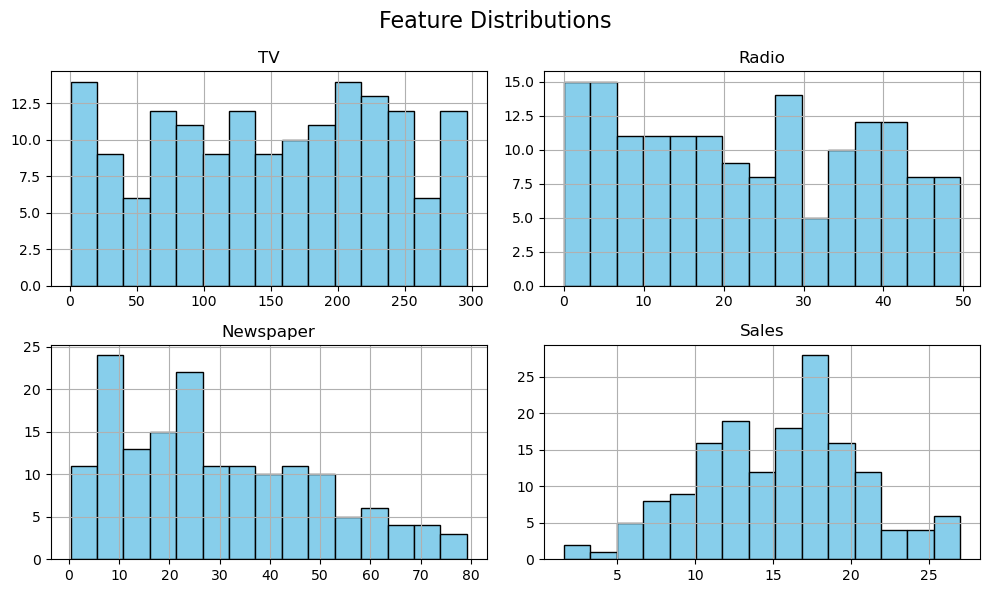

In [140]:
# Plot histograms of all features + target
train_df.hist(bins=15, figsize=(10, 6), layout=(2, 2), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()


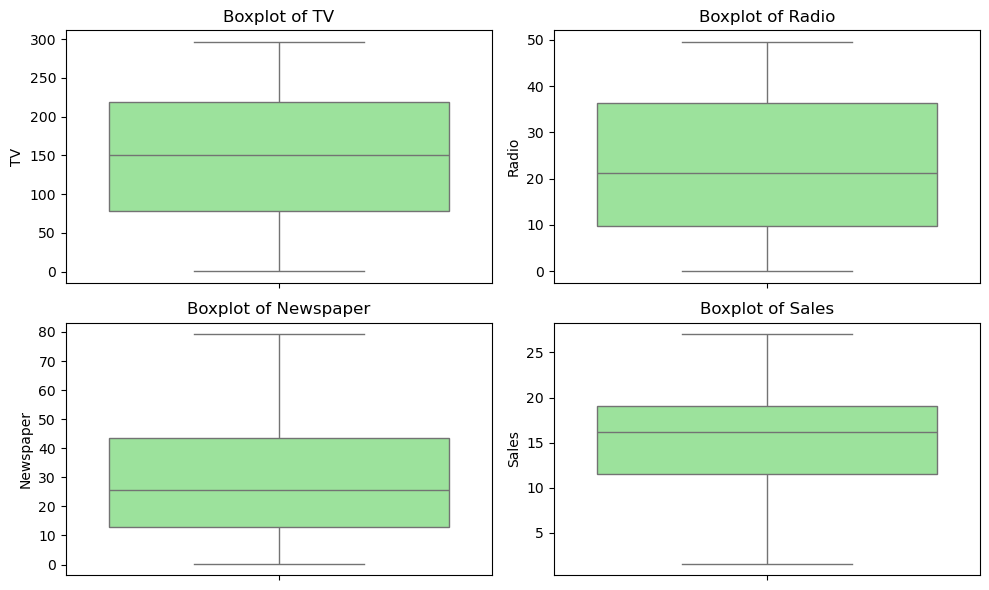

In [141]:
# Boxplots for each numerical column
plt.figure(figsize=(10, 6))
for i, column in enumerate(train_df.columns):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=train_df[column], color='lightgreen')
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()


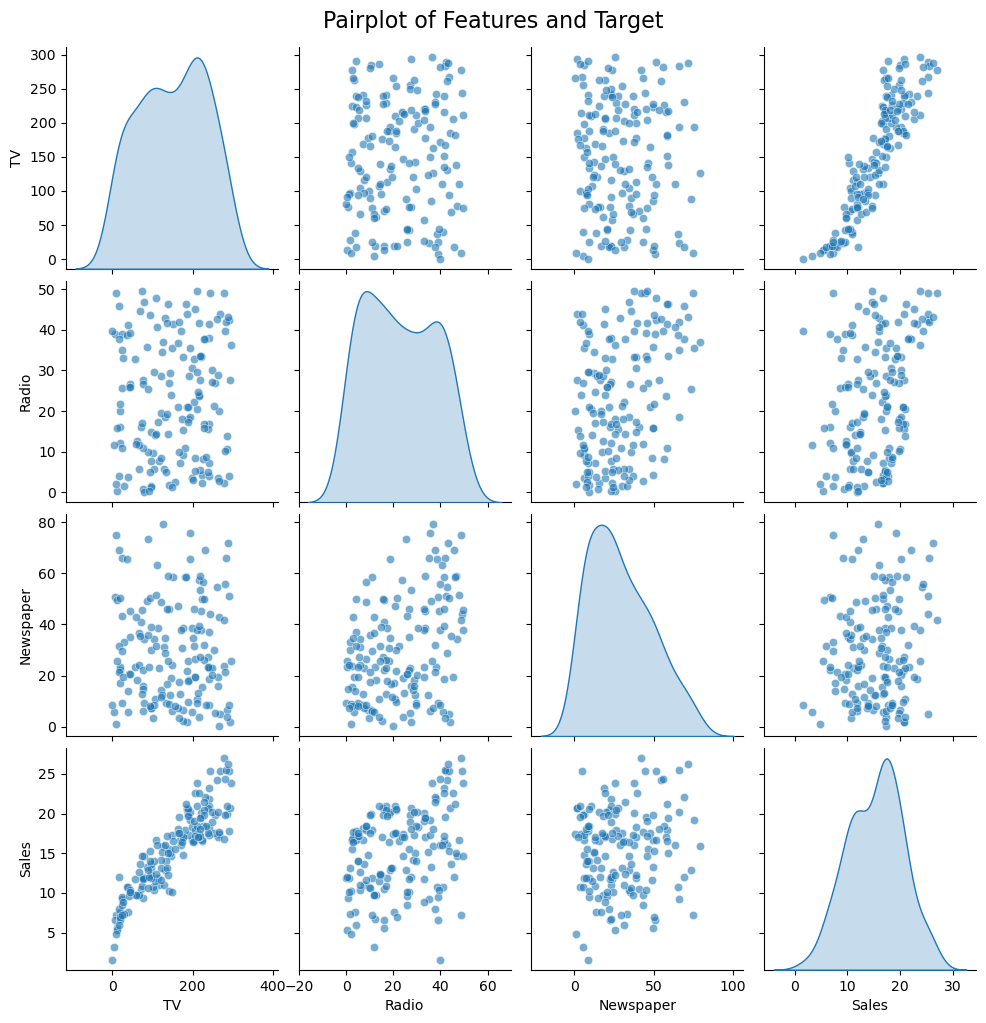

In [154]:
# Visualize pairwise relationships between all variables (including the target)
sns.pairplot(train_df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Features and Target', y=1.02, fontsize=16)
plt.show()

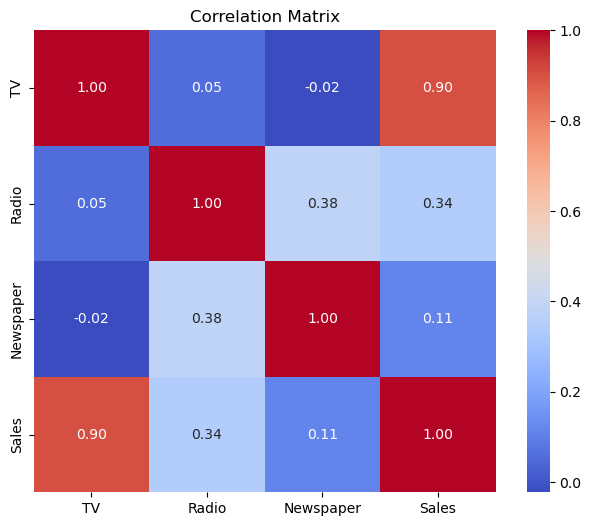

In [366]:
# Show the correlation matrix to understand linear relationships between variables
plt.figure(figsize=(8, 6))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

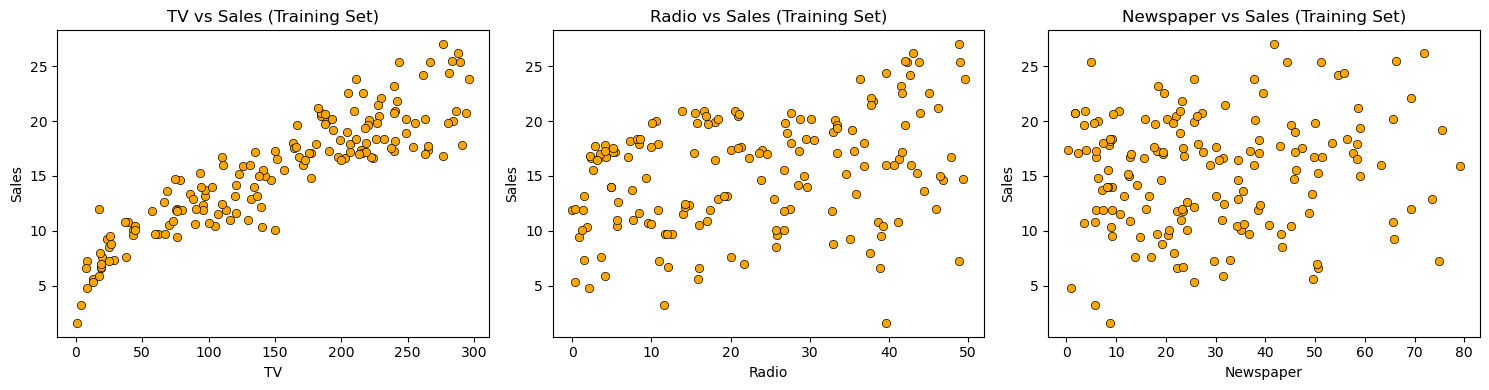

In [158]:
# Plot scatterplots to visually assess the relationship between each feature and the target (Sales)
plt.figure(figsize=(15, 4))

for i, feature in enumerate(['TV', 'Radio', 'Newspaper']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=train_df[feature], y=train_df['Sales'], color='orange', edgecolor='black')
    plt.title(f'{feature} vs Sales (Training Set)')
    plt.xlabel(feature)
    plt.ylabel('Sales')

plt.tight_layout()
plt.show()


# Preparing the Data

In [165]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

print("Shape of scaled training data:", X_train_scaled.shape)
print("Shape of scaled test data:", X_test_scaled.shape)

Shape of scaled training data: (160, 3)
Shape of scaled test data: (40, 3)


# Training Models

In [394]:
# 1. Train both models
w_normal, t_normal = utils.linear_regression_normal(X_train_scaled, y_train)
w_qr, t_qr = utils.linear_regression_qr(X_train_scaled, y_train)

# 2. Predictions on *test* set
y_pred_normal = utils.predict_linear_regression(w_normal, X_test_scaled)
y_pred_qr = utils.predict_linear_regression(w_qr, X_test_scaled)

# 3. Metrics
rss_norm = utils.rss(y_test, y_pred_normal)
rss_qr = utils.rss(y_test, y_pred_qr)

tss_val = utils.tss(y_test)
n, p = X_train.shape   

rse_norm = utils.rse(rss_norm, n, p)
rse_qr = utils.rse(rss_qr,   n, p)

f_norm = utils.f_statistic(rss_norm, tss_val, n, p)
f_qr = utils.f_statistic(rss_qr,   tss_val, n, p)

r2_norm = utils.r2_score(y_test, y_pred_normal)
r2_qr = utils.r2_score(y_test, y_pred_qr)

print(f"Normal Eq → Train time: {t_normal:.6f}s | RSS: {rss_norm:.4f} | RSE: {rse_norm:.4f} | F: {f_norm:.2f} | R2: {r2_norm}")
print(f"QR Decomp → Train time: {t_qr:.6f}s | RSS: {rss_qr:.4f}   | RSE: {rse_qr:.4f}   | F: {f_qr:.2f} | R2: {r2_qr}")

Normal Eq → Train time: 0.000348s | RSS: 117.5922 | RSE: 0.8682 | F: 494.59 | R2: 0.904864029274653
QR Decomp → Train time: 0.000000s | RSS: 117.5922   | RSE: 0.8682   | F: 494.59 | R2: 0.9048640292746528


Text(0, 0.5, 'Frequency')

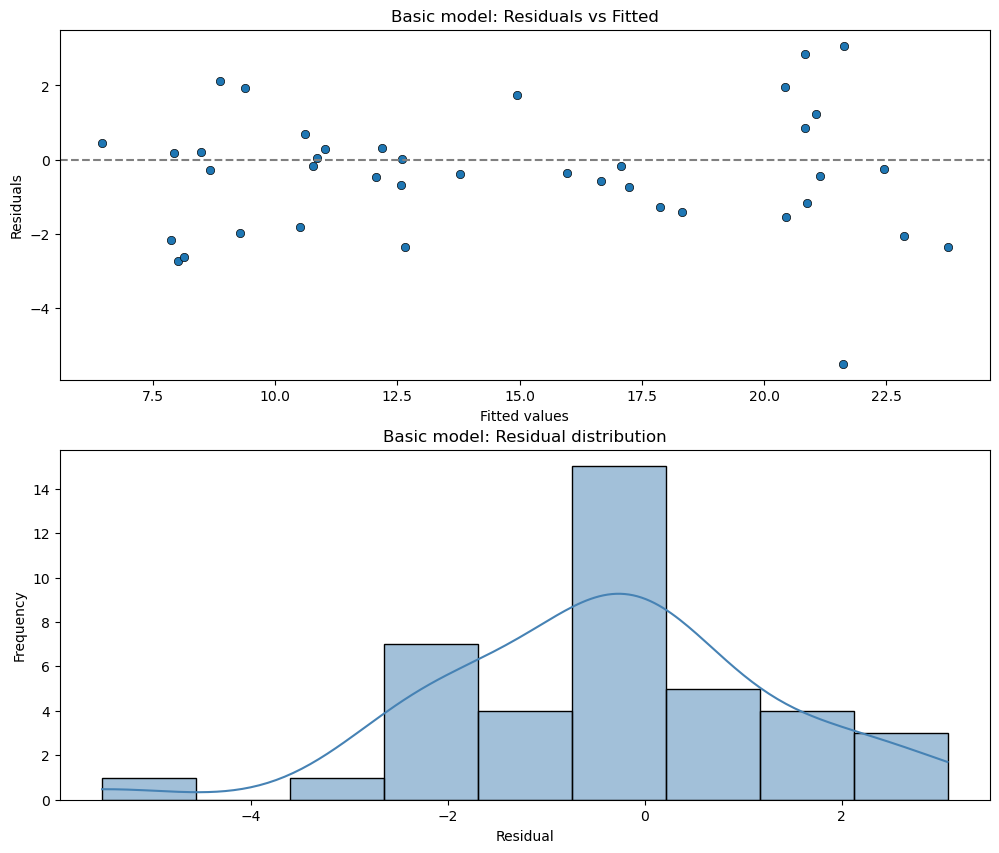

In [414]:
residuals_basic  = y_test - y_pred_normal

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# (a) Residuals vs Fitted — Basic
sns.scatterplot(x=y_pred_normal, y=residuals_basic, ax=axes[0], edgecolor="black")
axes[0].axhline(0, ls="--", color="grey")
axes[0].set_title("Basic model: Residuals vs Fitted")
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")

# (b) Histogram — Basic
sns.histplot(residuals_basic, kde=True, ax=axes[1], color="steelblue")
axes[1].set_title("Basic model: Residual distribution")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")

In [212]:
'''Both the Normal Equation and the QR Decomposition methods yielded identical results in terms of model performance,
with an RSS of 117.59, an RSE of approximately 0.868, and an F-statistic of 494.59.
These values indicate that the model explains a large proportion of the variance in the response variable, as supported by the high R² value of 0.9049.

This suggests that the linear model fits the data well and that the predictors, taken together,
have a statistically significant relationship with the target variable. 
However, individual variable significance still needs to be assessed using the t-statistics and p-values, which are computed in the next step.
This will allow us to determine which predictors contribute most to the model and which may be redundant or insignificant.'''

'Both the Normal Equation and the QR Decomposition methods yielded identical results in terms of model performance,\nwith an RSS of 117.59, an RSE of approximately 0.868, and an F-statistic of 494.59.\nThese values indicate that the model explains a large proportion of the variance in the response variable, as supported by the high R² value of 0.9049.\n\nThis suggests that the linear model fits the data well and that the predictors, taken together,\nhave a statistically significant relationship with the target variable. \nHowever, individual variable significance still needs to be assessed using the t-statistics and p-values, which are computed in the next step.\nThis will allow us to determine which predictors contribute most to the model and which may be redundant or insignificant.'

## Statistical Inference on Linear Regression Coefficients

In [233]:
# Let's see the inference for the model with normal equation
summary_df = utils.regression_summary(X_train_scaled, y_train, w_normal, feature_names=X_train_df.columns.tolist())
display(summary_df)

,Coefficient,Std. Error,t-Statistic,p-Value
intercept,15.330625,0.130853,117.158841,0.000000
TV,4.592044,0.131184,35.004500,0.000000
Radio,1.479175,0.141910,10.423360,0.000000
Newspaper,0.116577,0.141738,0.822479,0.412059


In [237]:
'''Although the p-value for the `Newspaper` variable is high (p ≈ 0.412), suggesting that it may not be statistically significant on its own, 
we choose not to remove it from the model just yet. Previous exploratory analysis, including the correlation heatmap, 
suggested that `Newspaper` has a notable interaction effect with the `Radio` variable.

This means that the influence of `Newspaper` might not manifest as a direct effect on the target variable, 
but rather as a **modulating factor** that enhances or diminishes the effect of another predictor. 
In this case, it appears that higher levels of newspaper advertising may amplify the effectiveness of radio advertising.

To account for such interaction effects, we extend our linear regression model by including an interaction term between `Radio` and `Newspaper`. 
This allows the model to capture more complex relationships between predictors that are not visible through additive effects alone.'''


'Although the p-value for the `Newspaper` variable is high (p ≈ 0.412), suggesting that it may not be statistically significant on its own, \nwe choose not to remove it from the model just yet. Previous exploratory analysis, including the correlation heatmap, \nsuggested that `Newspaper` has a notable interaction effect with the `Radio` variable.\n\nThis means that the influence of `Newspaper` might not manifest as a direct effect on the target variable, \nbut rather as a **modulating factor** that enhances or diminishes the effect of another predictor. \nIn this case, it appears that higher levels of newspaper advertising may amplify the effectiveness of radio advertising.\n\nTo account for such interaction effects, we extend our linear regression model by including an interaction term between `Radio` and `Newspaper`. \nThis allows the model to capture more complex relationships between predictors that are not visible through additive effects alone.'

## Model with Interaction Term

In [447]:
# Train with two features (columns 1 and 2 of X_train_scaled)
w_normal, _ = utils.linear_regression_normal(X_train_scaled[:, 1:3], y_train)

# Train model with interaction between columns 1 and 2
w_in = utils.train_interaction_model(X_train_scaled[:, 1], X_train_scaled[:, 2], y_train)

# Prediction using the same training columns (columns 1 and 2)
y_pred_normal = utils.predict_linear_regression(w_normal, X_test_scaled[:, 1:3])

# Model prediction with interaction
X1_test = X_test_scaled[:, 1]
X2_test = X_test_scaled[:, 2]
interaction_test = X1_test * X2_test
X_design_test = np.column_stack([np.ones_like(X1_test), X1_test, X2_test, interaction_test])
y_pred_in = X_design_test @ w_in

# Metrics calculation
rss_norm = utils.rss(y_test, y_pred_normal)
rss_in = utils.rss(y_test, y_pred_in)
tss_val = utils.tss(y_test)
n, p = X_train.shape

rse_norm = utils.rse(rss_norm, n, p)
rse_in = utils.rse(rss_in,   n, p)

f_norm = utils.f_statistic(rss_norm, tss_val, n, p)
f_in = utils.f_statistic(rss_in,   tss_val, n, p)

r2_norm = utils.r2_score(y_test, y_pred_normal)
r2_in = utils.r2_score(y_test, y_pred_in)

# Printing results
print(f"Normal Eq → RSS: {rss_norm:.4f} | RSE: {rse_norm:.4f} | F: {f_norm:.2f} | R2: {r2_norm}")
print(f"In Eq → RSS: {rss_in:.4f}   | RSE: {rse_in:.4f}   | F: {f_in:.2f} | R2: {r2_in}")


Normal Eq → RSS: 1115.2479 | RSE: 2.6738 | F: 5.63 | R2: 0.0977279779456689
In Eq → RSS: 1114.3853   | RSE: 2.6727   | F: 5.68 | R2: 0.09842585327786646


In [449]:
summary_df = utils.regression_summary(
    X_train_scaled[:, 1:3],
    y_train,
    w_normal,
    feature_names=["Radio", "Newspaper"]
)
display(summary_df)

,Coefficient,Std. Error,t-Statistic,p-Value
intercept,15.330625,0.388134,39.498311,0.000000
Radio,1.814314,0.419969,4.320112,0.000028
Newspaper,-0.113197,0.419969,-0.269537,0.787870


In [451]:
X1_train = X_train_scaled[:, 1]
X2_train = X_train_scaled[:, 2]
interaction_train = X1_train * X2_train
X_design_train = np.column_stack([np.ones_like(X1_train), X1_train, X2_train, interaction_train])

summary_df = utils.regression_summary(
    X_design_train[:, 1:4],
    y_train,
    w_in,
    feature_names=["Radio", "Newspaper", "Interaction"]
)
display(summary_df)

,Coefficient,Std. Error,t-Statistic,p-Value
intercept,15.337022,0.422143,36.331320,0.000000
Radio,1.814147,0.421333,4.305732,0.000029
Newspaper,-0.106984,0.450100,-0.237689,0.812434
Interaction,-0.016750,0.426983,-0.039230,0.968757


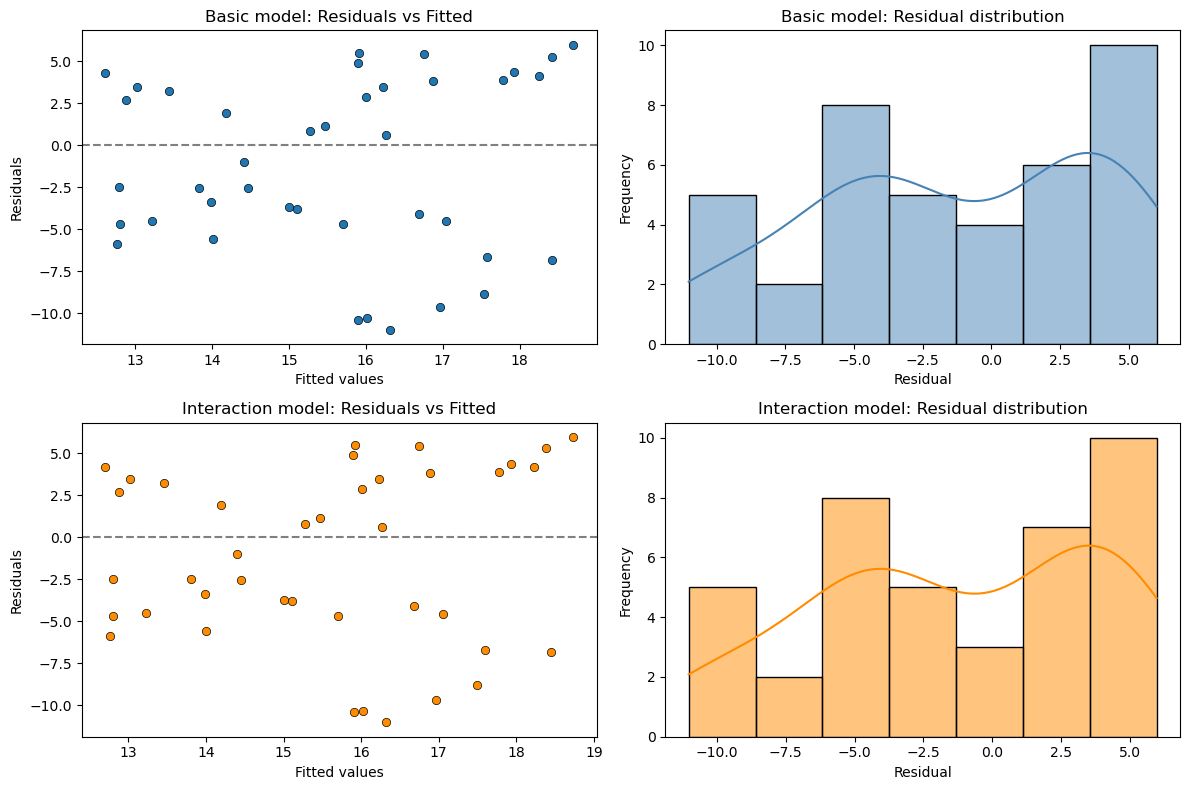

In [453]:
residuals_basic  = y_test - y_pred_normal
residuals_inter  = y_test - y_pred_in

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# (a) Residuals vs Fitted — Basic
sns.scatterplot(x=y_pred_normal, y=residuals_basic, ax=axes[0, 0], edgecolor="black")
axes[0, 0].axhline(0, ls="--", color="grey")
axes[0, 0].set_title("Basic model: Residuals vs Fitted")
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")

# (b) Histogram — Basic
sns.histplot(residuals_basic, kde=True, ax=axes[0, 1], color="steelblue")
axes[0, 1].set_title("Basic model: Residual distribution")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# (c) Residuals vs Fitted — Interaction
sns.scatterplot(x=y_pred_in, y=residuals_inter, ax=axes[1, 0], edgecolor="black", color="darkorange")
axes[1, 0].axhline(0, ls="--", color="grey")
axes[1, 0].set_title("Interaction model: Residuals vs Fitted")
axes[1, 0].set_xlabel("Fitted values")
axes[1, 0].set_ylabel("Residuals")

# (d) Histogram — Interaction
sns.histplot(residuals_inter, kde=True, ax=axes[1, 1], color="darkorange")
axes[1, 1].set_title("Interaction model: Residual distribution")
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

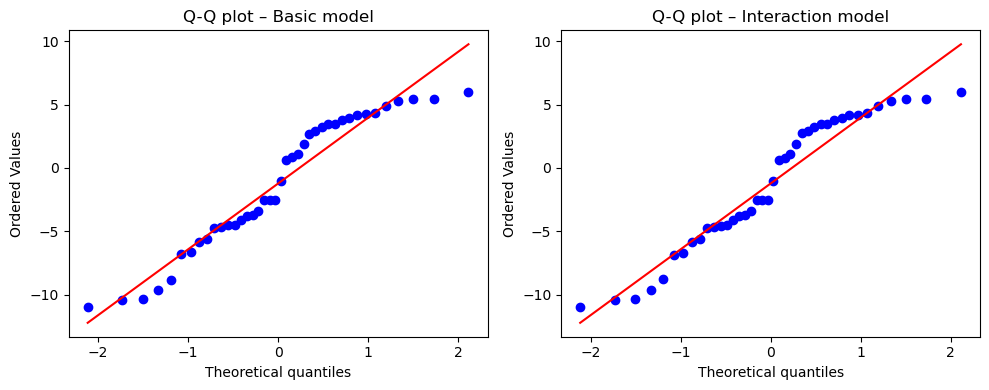

In [454]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
stats.probplot(residuals_basic, dist="norm", plot=ax[0])
ax[0].set_title("Q-Q plot – Basic model")
stats.probplot(residuals_inter, dist="norm", plot=ax[1])
ax[1].set_title("Q-Q plot – Interaction model")
plt.tight_layout()
plt.show()

## Variance Inflation Factor (VIF) and Confidence Intervals

In [456]:
'''To further assess our linear regression model, we implemented two key diagnostic tools from scratch:

1. **Variance Inflation Factor (VIF):**  
   VIF quantifies the multicollinearity between each predictor and the others. 
   A high VIF (typically >10) suggests that the feature is highly correlated with others and may inflate the variance of the coefficient estimates.

2. **Confidence Intervals for Coefficients:**  
   Using the t-distribution, we compute 95% confidence intervals for each estimated coefficient. 
   If the interval includes zero, the coefficient may not be statistically significant.

> Note: Despite the interaction term being theoretically important (as suggested in ISLP), 
    it appears not to be statistically significant in this dataset. 
    This could be due to multicollinearity or the interaction not contributing substantial explanatory power in our case.'''

'To further assess our linear regression model, we implemented two key diagnostic tools from scratch:\n\n1. **Variance Inflation Factor (VIF):**  \n   VIF quantifies the multicollinearity between each predictor and the others. \n   A high VIF (typically >10) suggests that the feature is highly correlated with others and may inflate the variance of the coefficient estimates.\n\n2. **Confidence Intervals for Coefficients:**  \n   Using the t-distribution, we compute 95% confidence intervals for each estimated coefficient. \n   If the interval includes zero, the coefficient may not be statistically significant.\n\n> Note: Despite the interaction term being theoretically important (as suggested in ISLP), \n    it appears not to be statistically significant in this dataset. \n    This could be due to multicollinearity or the interaction not contributing substantial explanatory power in our case.'

In [458]:
# Feature matrix: Base model
X_base = X_train_scaled[:, [1, 2]]  # Radio and Newspaper only
feature_names_base = ["Radio", "Newspaper"]

# Feature matrix: With interaction
interaction_term = X_train_scaled[:, 1] * X_train_scaled[:, 2]
X_interaction = np.column_stack([X_train_scaled[:, 1], X_train_scaled[:, 2], interaction_term])
feature_names_interaction = ["Radio", "Newspaper", "Interaction"]

# Compute VIFs
vif_base = utils.calculate_vif_manual(X_base, feature_names_base)
vif_interaction = utils.calculate_vif_manual(X_interaction, feature_names_interaction)

# Display results
print("VIF (Base model):")
display(vif_base)

print("\nVIF (With interaction):")
display(vif_interaction)

VIF (Base model):


,Feature,VIF
0,Radio,1.170772
1,Newspaper,1.170772



VIF (With interaction):


,Feature,VIF
0,Radio,1.170893
1,Newspaper,1.336241
2,Interaction,1.162174


In [491]:
# Add intercept
X_base_sm = sm.add_constant(X_base)
model_base = sm.OLS(y_train, X_base_sm).fit()

# Confidence intervals (95%)
ci_base = pd.DataFrame(model_base.conf_int(alpha=0.05),
                       columns=["Lower Bound", "Upper Bound"],
                       index=["Intercept"] + feature_names_base)

print("Confidence Intervals (Base model):")
display(ci_base)


Confidence Intervals (Base model):


,Lower Bound,Upper Bound
Intercept,14.563988,16.097262
Radio,0.984796,2.643833
Newspaper,-0.942716,0.716321


In [489]:
# Add intercept
interaction = (X_train_scaled[:, 1] * X_train_scaled[:, 2]).reshape(-1, 1)

X_interaction_sm = np.column_stack([X_base, interaction])
X_interaction_sm = sm.add_constant(X_interaction_sm)

model_inter = sm.OLS(y_train, X_interaction_sm).fit()

ci_inter = pd.DataFrame(model_inter.conf_int(alpha=0.05),
                        columns=["Lower Bound", "Upper Bound"],
                        index=["Intercept"] + feature_names_interaction)

print("Confidence Intervals (With interaction):")
display(ci_inter)


Confidence Intervals (With interaction):


,Lower Bound,Upper Bound
Intercept,14.503168,16.170877
Radio,0.981893,2.646400
Newspaper,-0.996061,0.782093
Interaction,-0.860165,0.826665


# Conclusion

In [502]:
'''In this notebook, we built a linear regression model to predict product sales based on advertising investments in Radio and Newspaper.
The model with interaction terms showed a slight improvement, although the interaction coefficient was not statistically significant. 
TV advertising remained the most important predictor, while Newspaper had a weaker and possibly negligible effect.
Future work could include using polynomial terms or regularized models to further explore non-linear relationships.'''

'In this notebook, we built a linear regression model to predict product sales based on advertising investments in Radio and Newspaper.\nThe model with interaction terms showed a slight improvement, although the interaction coefficient was not statistically significant. \nTV advertising remained the most important predictor, while Newspaper had a weaker and possibly negligible effect.\nFuture work could include using polynomial terms or regularized models to further explore non-linear relationships.'